<a href="https://colab.research.google.com/github/DomenicoArmillotta/Adversarial_patch/blob/main/Adversarial_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   modifica codice , forzare a sbagliare una sola classe
* altro mdetodo magari gan



# **Esempio Resnet -->  prova 2**

Accuratezza prima della patch: 4.29%


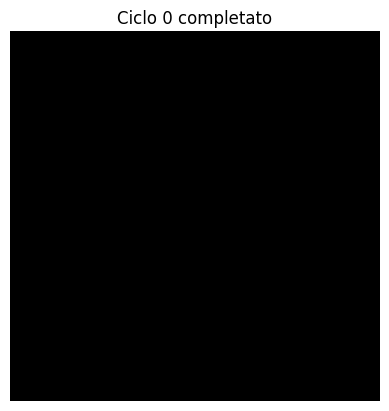

Ciclo 0 completato


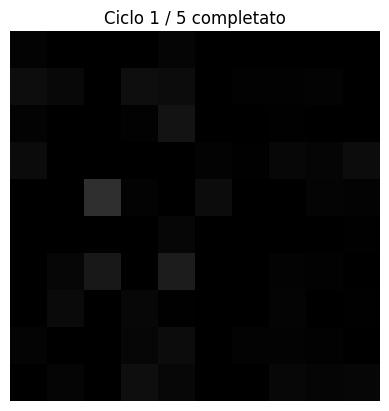

Ciclo 1 / 5 completato


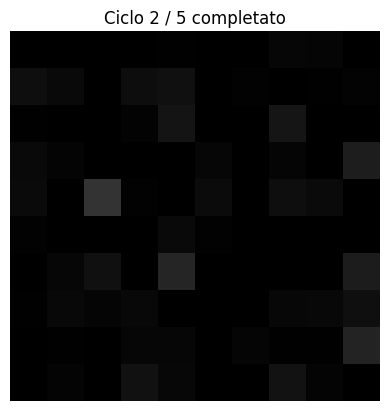

Ciclo 2 / 5 completato


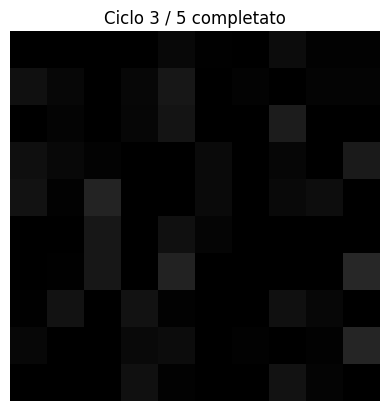

Ciclo 3 / 5 completato


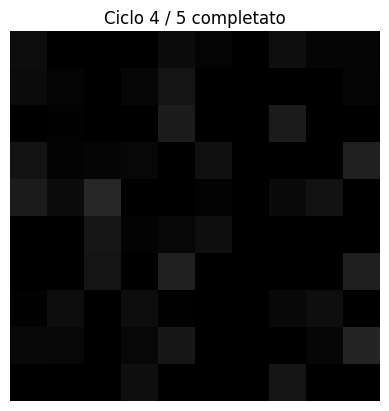

Ciclo 4 / 5 completato


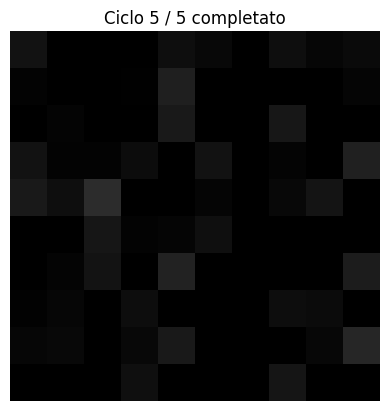

Ciclo 5 / 5 completato


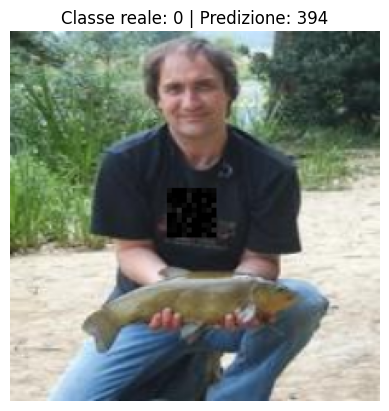

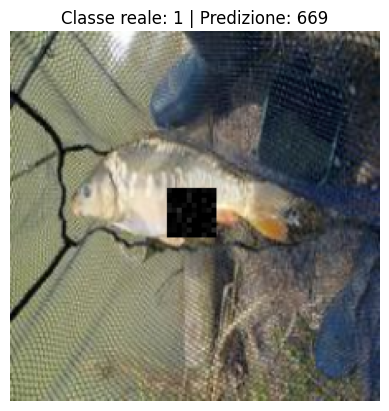

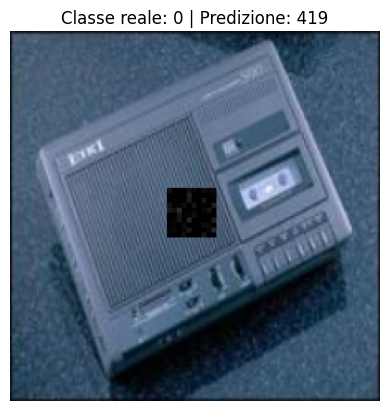

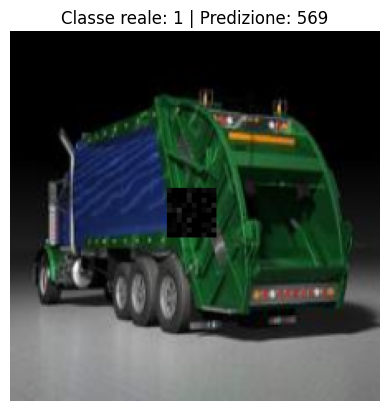

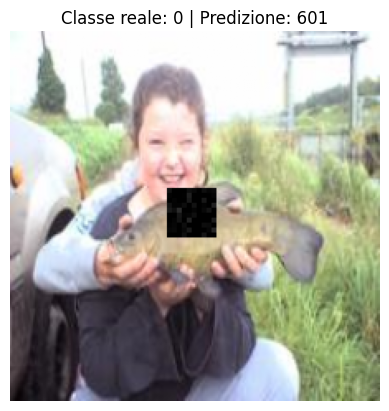

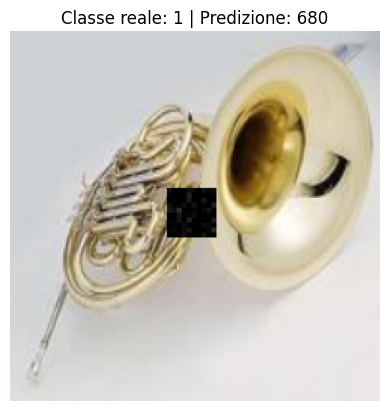

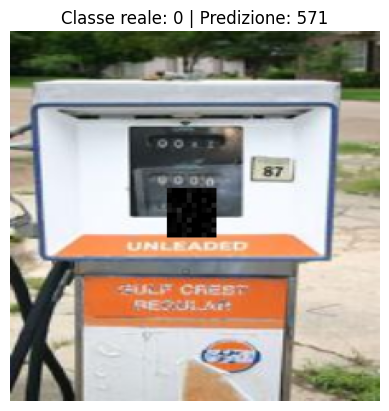

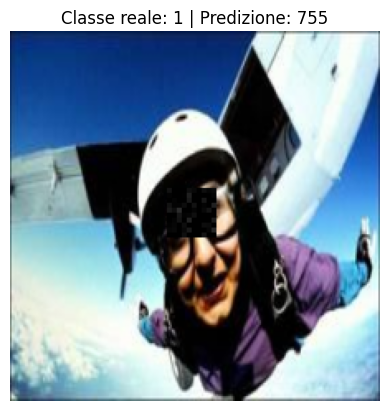

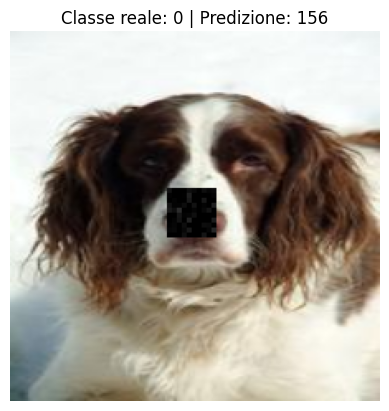

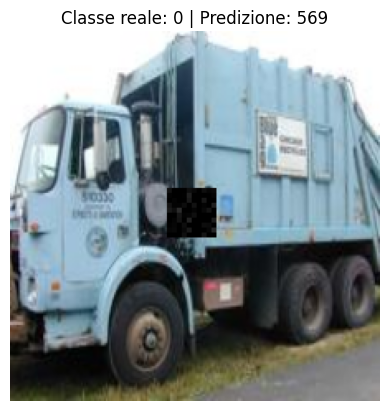

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import tarfile

# Funzione per scaricare ed estrarre il dataset
def download_and_extract_dataset(url, download_path, extract_path):
    if not os.path.exists(download_path):
        os.makedirs(download_path)
    dataset_tar = os.path.join(download_path, 'dataset.tgz')

    # Scarica il dataset
    if not os.path.isfile(dataset_tar):
        print('Scaricando il dataset...')
        urllib.request.urlretrieve(url, dataset_tar)
        print('Download completato.')

    # Estrai il dataset
    if not os.path.exists(extract_path):
        print('Estraendo il dataset...')
        with tarfile.open(dataset_tar, 'r:gz') as tar_ref:
            tar_ref.extractall(download_path)
        print('Estrazione completata.')

# Percorso e URL del dataset
url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz'
download_path = 'data'
extract_path = os.path.join(download_path, 'imagenette2-160')

# Scarica ed estrai il dataset
download_and_extract_dataset(url, download_path, extract_path)

# Funzione per ottenere il dataloader del dataset
def get_dataset(extract_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    dataset = datasets.ImageFolder(root=extract_path, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    return data_loader


# Funzione per creare la patch avversaria
def create_adversarial_patch(model, target_class, data_loader, num_iterations=100, patch_size_ratio=0.15, grid_size=10, device='cuda'):
    patch_size = int(224 * patch_size_ratio)
    cell_size = patch_size // grid_size
    # Inizializzazione della patch a zero (tutto nero)
    patch = torch.zeros((3, grid_size, grid_size), requires_grad=True, device=device)
    plt.imshow(patch.permute(1, 2, 0).cpu().detach().numpy())
    plt.title(f'Ciclo 0 completato')
    plt.axis('off')
    plt.show()
    print(f'Ciclo 0 completato')

    optimizer = optim.Adam([patch], lr=0.1)

    for i, (images, labels) in enumerate(data_loader):
        if i >= num_iterations:
            break

        images = images.to(device)
        optimizer.zero_grad()

        # Posizionare la patch al centro dell'immagine
        images_with_patch = images.clone()
        start_x = (224 - patch_size) // 2
        start_y = (224 - patch_size) // 2
        for x in range(grid_size):
            for y in range(grid_size):
                images_with_patch[:, :, start_y + y*cell_size : start_y + (y+1)*cell_size,
                                  start_x + x*cell_size : start_x + (x+1)*cell_size] = patch[:, y, x].view(3, 1, 1)

        output = model(images_with_patch)
        target = torch.tensor([target_class] * images.size(0), device=device)

        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()

        # Aggregare i gradienti per ogni cella
        with torch.no_grad():
            for x in range(grid_size):
                for y in range(grid_size):
                    cell_gradient = patch.grad[:, y, x].mean()
                    patch[:, y, x] -= cell_gradient * 1  # Applica una modifica proporzionale al gradiente medio
                    patch.grad[:, y, x].zero_()

        optimizer.step()

        # Stampa del numero di ciclo e visualizzazione della patch
        if (i + 1) % 1 == 0:
            plt.imshow(patch.permute(1, 2, 0).cpu().detach().numpy())
            plt.title(f'Ciclo {i + 1} / {num_iterations} completato')
            plt.axis('off')
            plt.show()
            print(f'Ciclo {i + 1} / {num_iterations} completato')

    return patch


# Funzione per valutare le performance del modello e visualizzare 10 esempi
def evaluate_model(model, data_loader, patch=None, device='cuda', show_example=True):
    model.eval()
    correct = 0
    total = 0
    example_count = 0  # Contatore per 10 immagini
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            if patch is not None:
                # Applicare la patch al centro dell'immagine
                patch_size = int(224 * 0.15)  # Dimensione totale della patch (es. 15% del lato dell'immagine)
                cell_size = patch_size // 10  # Dimensione delle celle in cui è suddivisa la patch
                start_x = (224 - patch_size) // 2
                start_y = (224 - patch_size) // 2
                for x in range(10):
                    for y in range(10):
                        images[:, :, start_y + y*cell_size : start_y + (y+1)*cell_size,
                               start_x + x*cell_size : start_x + (x+1)*cell_size] = patch[:, y, x].view(3, 1, 1)

            # Passa l'immagine con patch al modello per la predizione
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Mostra 10 immagini con la patch applicata
            if show_example and example_count < 10:
                image_with_patch = images[0].cpu().permute(1, 2, 0).numpy()
                plt.imshow(image_with_patch)
                plt.title(f'Classe reale: {labels[0].item()} | Predizione: {predicted[0].item()}')
                plt.axis('off')
                plt.show()
                example_count += 1

    return 100 * correct / total

# Impostazioni e configurazioni
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True).to(device)
data_loader = get_dataset(extract_path)

# Parametri per la patch avversaria
target_class = 0
num_iterations = 5

# Valutazione delle performance prima
accuracy_before = evaluate_model(model, data_loader, show_example=False)
print(f'Accuratezza prima della patch: {accuracy_before:.2f}%')

# Creazione della patch avversaria
patch = create_adversarial_patch(model, target_class, data_loader, num_iterations=num_iterations, device=device)

# Valutazione delle performance dopo con visualizzazione di 10 esempi
accuracy_after = evaluate_model(model, data_loader, patch=patch, show_example=True)
print(f'Accuratezza dopo la patch: {accuracy_after:.2f}%')

# Salva e stampa la patch
patch_image = patch.repeat_interleave(224 // 10, dim=1).repeat_interleave(224 // 10, dim=2)

# Visualizzazione della patch creata
plt.imshow(patch_image.permute(1, 2, 0).cpu().detach().numpy())
plt.title('Patch Avversaria Creata')
plt.axis('off')
plt.show()
